# MLofi: Model training

## Setup

### Hyperparameters

This parameter configures the length of the sequences used for the prediction. The sequences are fixed-length due to how recurrent links are implemented.

This parameter is particularly interesting, as it determines how much data in the past can the network access.

Due to the nature of the parameter, it also represents the length of the seed used to generate new songs.

In [1]:
sequence_length = 30
# possible values ["srnn", "lstm", "gru"]
model_type = "lstm"

### Imports

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, Activation

from tensorflow.keras.layers import  SimpleRNN, GRU

from music21 import *

import numpy as np

import os
import re

### Mount Google Drive to access the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def create_path(relative_path):
  return f'/content/drive/My Drive/MLofi/{relative_path}'

In [5]:
dataset_directory = create_path('datasets/lofi-hip-hop-midi')
path_to_unique_notes = create_path('output/data/unique_notes.txt')

## Training

### Loading the datasets

The following datasets were used:
- [Lo-Fi Hip Hop MIDIs](https://www.kaggle.com/zakarii/lofi-hip-hop-midi/metadata)
  by *zakarii*
- [Lo-fi samples](https://github.com/nmtremblay/lofi-samples) by *nmtremblay*

#### Navigating and reading the songs

In [6]:
def read_song(song):
  song_elements = []

  for element in song.recurse():   
    if isinstance(element, note.Note):
      song_elements.append(str(element.pitch))
    elif isinstance(element, chord.Chord):
      song_elements.append('.'.join(str(n) for n in element.normalOrder))
    elif isinstance(element, note.Rest):
      # song_elements.append(str(element.fullName))
      pass

  return song_elements

In [7]:
# The `songs` list holds the notes and chords for every song in the dataset
songs = []

for subdirs, dirs, files in os.walk(dataset_directory):
  for file in files:
    current_song_path = os.path.join(subdirs, file)
    current_song_parse = converter.parse(current_song_path)
           
    songs.append(read_song(current_song_parse))

#### Processing the datasets

##### Flattening the songs

The song elements (notes, chords, and rests) from the songs are flattened into a single
list.

In [8]:
def flatten_songs(songs):
  elements = []

  for song in songs:
    # Paddings signal a song's beginning
    # elements.append('Padding')

    for element in song:
        elements.append(element)

  return elements

In [9]:
all_notes = flatten_songs(songs)
unique_notes = list(set(all_notes))
note_to_index = dict([(note, index) for index, note in enumerate(unique_notes)])
unique_note_count = len(unique_notes)
unique_note_count

249

##### Creating the note, chord and rest collection

In [10]:
with open(path_to_unique_notes, "w") as f:
  f.write(str("\n".join(unique_notes)))

##### Transforming the datasets into sequences

In [11]:
sequences = []        # a sequence is the input to the network
following_notes = []  # the corresponding notes we're trying to predict

for i in range(sequence_length, len(all_notes)):
    sequence = all_notes[i - sequence_length : i]
    result = all_notes[i]
    
    sequences.append([[note_to_index[note]] for note in sequence])
    following_notes.append(note_to_index[result])
sequences = np.array(sequences)

##### One-hot encoding the song elements

In [12]:
X = keras.utils.to_categorical(sequences, num_classes=unique_note_count)
y = keras.utils.to_categorical(following_notes, num_classes=unique_note_count)

### Defining the model

In [16]:
if model_type == "lstm":
  input = Input(shape=(sequence_length, unique_note_count))
  hidden_1 = Dropout(0.3)(LSTM(700, return_sequences=True, recurrent_dropout=0.2)(input))
  hidden_2 = Dropout(0.3)(LSTM(700, return_sequences=True, recurrent_dropout=0.2)(Concatenate()([input, hidden_1])))
  hidden_3 = Dropout(0.3)(LSTM(700, return_sequences=True, recurrent_dropout=0.2)(Concatenate()([input, hidden_2])))
  distribution_parameters = LSTM(700, recurrent_dropout=0.3)(Concatenate()([hidden_1, hidden_2, hidden_3]))
  distribution = Dense(unique_note_count)(distribution_parameters)
elif model_type == "gru":
  input = Input(shape=(sequence_length, unique_note_count))
  hidden_1 = Dropout(0.3)(GRU(700, return_sequences=True, recurrent_dropout=0.3)(input))
  hidden_2 = Dropout(0.3)(GRU(700, return_sequences=True, recurrent_dropout=0.3)(Concatenate()([input, hidden_1])))
  hidden_3 = Dropout(0.3)(GRU(700, return_sequences=True, recurrent_dropout=0.3)(Concatenate()([input, hidden_2])))
  distribution_parameters = GRU(700, recurrent_dropout=0.3)(Concatenate()([hidden_1, hidden_2, hidden_3]))
  distribution = Dense(unique_note_count)(distribution_parameters)
elif model_type == "srnn":
  input = Input(shape=(sequence_length, unique_note_count))
  hidden_1 = Dropout(0.3)(SimpleRNN(700, return_sequences=True)(input))
  hidden_2 = Dropout(0.3)(SimpleRNN(700, return_sequences=True)(Concatenate()([input, hidden_1])))
  hidden_3 = Dropout(0.3)(SimpleRNN(700, return_sequences=True)(Concatenate()([input, hidden_2])))
  distribution_parameters = SimpleRNN(700)(Concatenate()([hidden_1, hidden_2, hidden_3]))
  distribution = Dense(unique_note_count)(distribution_parameters)

output = Activation('softmax')(distribution)
model = keras.Model(inputs=input, outputs=output, name='MLofi')

In [37]:
# input = Input(shape=(sequence_length, unique_note_count))
# hidden_1 = Dropout(0.3)(LSTM(512, return_sequences=True)(input))
# hidden_2 = Dropout(0.3)(LSTM(512, return_sequences=True)(hidden_1))
# hidden_3 = Dropout(0.3)(LSTM(512, return_sequences=True)(hidden_2))
# hidden_4 = LSTM(512)(hidden_3)
# dense_1 = Dropout(0.3)(Dense(512)(hidden_4))
# dense_2 = Dense(unique_note_count)(dense_1)
# output = Activation('softmax')(dense_2)

# model = keras.Model(inputs=input, outputs=output)

In [38]:
model.summary()

Model: "MLofi"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30, 249)]    0           []                               
                                                                                                  
 lstm_4 (LSTM)                  (None, 30, 700)      2660000     ['input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 30, 700)      0           ['lstm_4[0][0]']                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 30, 949)      0           ['input_2[0][0]',                
                                                                  'dropout[0][0]']            

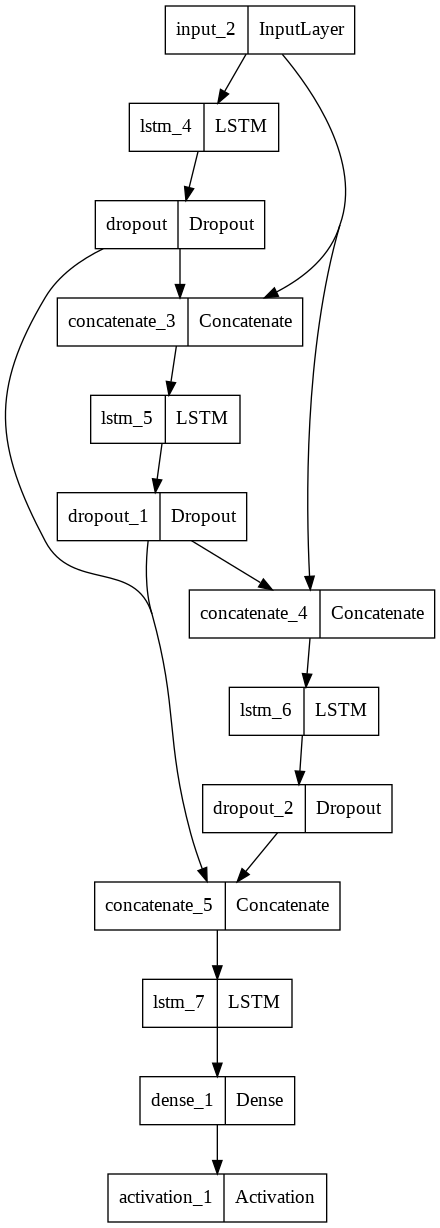

In [39]:
keras.utils.plot_model(model, "model.png")

### Compiling and training the model

In [40]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [41]:
filepath = create_path("weights/weights.hdf5")
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [42]:
history = model.fit(X, y, epochs=25, batch_size=64, callbacks=callbacks_list)

Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 5.0047 - accuracy: 0.0430
Epoch 00001: loss improved from inf to 5.00469, saving model to /content/drive/My Drive/MLofi/weights/weights.hdf5
34/34 [==============================] - 44s 1s/step - loss: 5.0047 - accuracy: 0.0430
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 4.5963 - accuracy: 0.0585
Epoch 00002: loss improved from 5.00469 to 4.59627, saving model to /content/drive/My Drive/MLofi/weights/weights.hdf5
34/34 [==============================] - 37s 1s/step - loss: 4.5963 - accuracy: 0.0585
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 4.3284 - accuracy: 0.0883
Epoch 00003: loss improved from 4.59627 to 4.32839, saving model to /content/drive/My Drive/MLofi/weights/weights.hdf5
34/34 [==============================] - 37s 1s/step - loss: 4.3284 - accuracy: 0.0883
Epoch 4/25
34/34 [==============================] - ETA: 0s - loss: 4.1521 - accuracy: 0.0873
Epoch 0000